In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from scipy import stats
from whats_your_bench.problem_set import Problem1
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
from itertools import product
import torch

# One dimension

In [3]:
data = stats.norm.rvs(10, 30, 1000)

data.shape

(1000,)

In [6]:
normal_with_var = cp.NormalKnownVar(30, [0, 1])

normal_with_var.find_predictive_posterior(data)

print(normal_with_var.prior_params)
print(normal_with_var.posterior_params)
print(normal_with_var.posterior_predictive_params)

mean, sigma = normal_with_var.posterior_predictive_params.mu, normal_with_var.posterior_predictive_params.sigma

namespace(mu=0, sigma=1)
namespace(mu=9.55590778971325, sigma=0.029126213592233007)
namespace(mu=9.55590778971325, sigma=30.02912621359223)


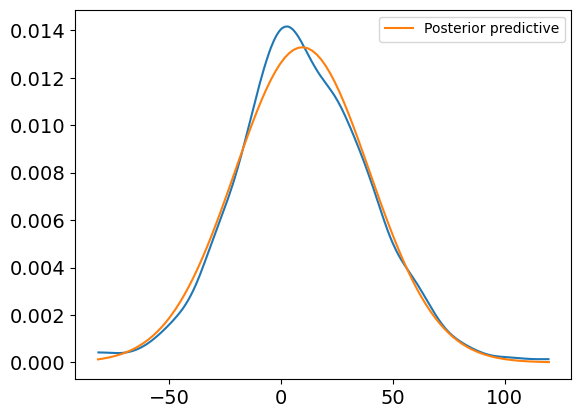

In [8]:
fig, ax = plt.subplots()

az.plot_kde(data, ax = ax)
x = np.linspace(data.min(), data.max(), 100)
ax.plot(x, stats.norm.pdf(x, mean, sigma), color = "C1", label = "Posterior predictive")
ax.legend()
plt.show();

In [4]:
normal_with_mean = cp.NormalKnownMean(5, [0, 1], data)

print(normal_with_mean.prior_params)
print(normal_with_mean.posterior_params)
print(normal_with_mean.posterior_predictive_params)

df = normal_with_mean.posterior_predictive_params["nu"]
loc = normal_with_mean.posterior_predictive_params["loc"]
scale = normal_with_mean.posterior_predictive_params["scale"]

{'alpha': 0, 'beta': 1}
{'alpha': 500.0, 'beta': 481510.18653784785}
{'k': 500.0, 'loc': 5, 'scale': 31.03256955322417}


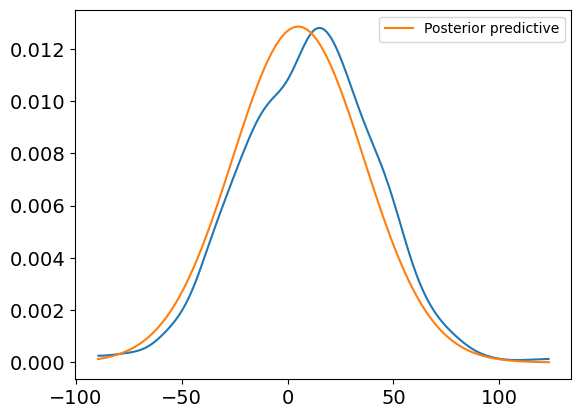

In [5]:
fig, ax = plt.subplots()

az.plot_kde(data, ax = ax)
x = np.linspace(data.min(), data.max(), 100)
ax.plot(x, stats.t.pdf(x, df, loc, scale), color = "C1", label = "Posterior predictive")
ax.legend()
plt.show();

# Multi-dimensional

In [18]:
mv_data = stats.multivariate_normal.rvs([3, 6], [[1, 0.5],[0.5, 1]], size = (10,))

In [4]:
mv_normal_known_cov = cp.MvNormalKnownCov(
    np.array([[1, 0.5], [0.5, 1]]),
    [
        [0, 0],
        np.array([[1, 0], [0, 1]])
    ],
    mv_data
)

prior_mean, prior_cov = [
        [0, 0],
        np.array([[1, 0], [0, 1]])
    ]
post_mean, post_cov = mv_normal_known_cov.posterior_predictive_params["mean"], mv_normal_known_cov.posterior_predictive_params["covariance"]

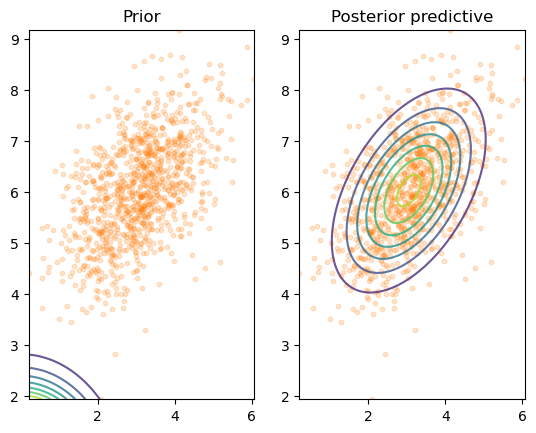

In [5]:
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(mv_data[:, 0].min(), mv_data[:, 0].max(), 100)
z2 = np.linspace(mv_data[:, 1].min(), mv_data[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

ax[0].contour(x, y, stats.multivariate_normal.pdf(pos, mean = prior_mean, cov = prior_cov), alpha = 0.8)
ax[1].contour(x, y, stats.multivariate_normal.pdf(pos, mean = post_mean, cov = post_cov), alpha = 0.8)
ax[0].scatter(mv_data[:, 0], mv_data[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].scatter(mv_data[:, 0], mv_data[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Prior")
ax[1].set_title("Posterior predictive")

plt.show();

In [21]:
mv_data = stats.multivariate_normal.rvs([3, 6], [[1, 0.5],[0.5, 1]], size = (2,))

In [35]:
mv_data.mean(axis = 1)

array([5.88207594, 4.16087419])

In [36]:
mv_normal_known_mean = cp.MvNormalKnownMean(
    mv_data.mean(axis = 0),
    [
        3,
        np.array([[2, 2], [2, 2]])
    ],
    mv_data
)

mean = mv_data.mean(axis = 0)
prior_df, prior_scale = [3, np.array([[1, 0], [0, 1]])]
post_df, post_loc, post_scale = mv_normal_known_mean.posterior_predictive_params["df"], mv_normal_known_mean.posterior_predictive_params["loc"], mv_normal_known_mean.posterior_predictive_params["scale"]

print(mv_normal_known_mean.prior_params)
print(mv_normal_known_mean.posterior_params)
print(mv_normal_known_mean.posterior_predictive_params)

{'df': 3, 'scale': array([[2, 2],
       [2, 2]])}
{'df': 5, 'scale': array([[2., 2.],
       [2., 2.]])}
{'df': 4, 'loc': array([3.5222885 , 6.52066162]), 'scale': array([[0.5, 0.5],
       [0.5, 0.5]])}


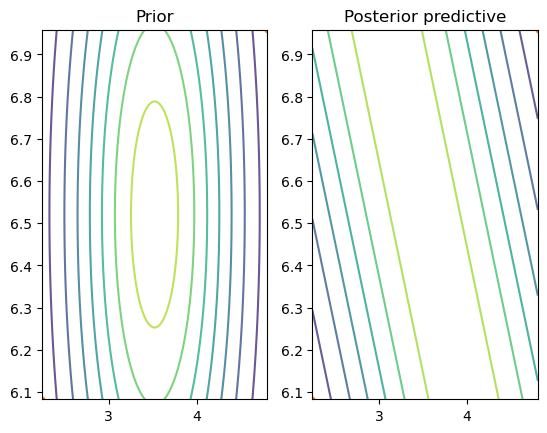

In [39]:
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(mv_data[:, 0].min(), mv_data[:, 0].max(), 100)
z2 = np.linspace(mv_data[:, 1].min(), mv_data[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

ax[0].contour(x, y, stats.multivariate_t.pdf(pos, loc = mean, shape = prior_scale, df = prior_df), alpha = 0.8)
ax[1].contour(x, y, stats.multivariate_t.pdf(pos, loc = post_loc, shape = post_scale, df = post_df, allow_singular = True), alpha = 0.8)
ax[0].scatter(mv_data[:, 0], mv_data[:, 1], 10, alpha = 1, color = "C1")
ax[1].scatter(mv_data[:, 0], mv_data[:, 1], 10, alpha = 1, color = "C1")

ax[0].set_title("Prior")
ax[1].set_title("Posterior predictive")

plt.show();

# DDKS Distance Checks

## Visualising

In [30]:
samples = stats.multivariate_normal([4,4], [[1,0],[0,1]]).rvs(100)

analytic_cdf = stats.multivariate_normal([3, 4], [[2, 1], [1, 2]]).cdf(samples)

In [31]:
samples.sort()
analytic_cdf.sort()

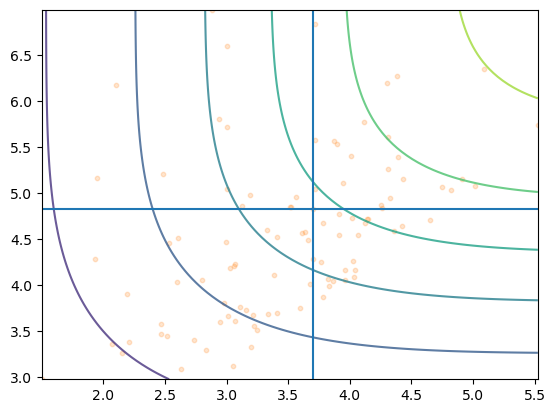

[[False False]
 [False  True]
 [ True False]
 [ True  True]] [41 13 22 24]


In [60]:
test_idx = np.random.randint(0, high = samples.shape[0])
test_point = samples[test_idx]

fig, ax = plt.subplots()

x = samples[:, 0]
y = samples[:, 1]

z1 = np.linspace(samples[:, 0].min(), samples[:, 0].max(), 100)
z2 = np.linspace(samples[:, 1].min(), samples[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

ax.contour(x, y, stats.multivariate_normal.cdf(pos, mean = [3, 4], cov = [[2, 1], [1, 2]]), alpha = 0.8)
ax.scatter(samples[:, 0], samples[:, 1], 10, alpha = 0.2, color = "C1")

ax.vlines(test_point[0], ymin = y.min(), ymax = y.max())
ax.hlines(test_point[1], xmin = x.min(), xmax = x.max())

plt.show();

mask = samples >= test_point

unique, counts = np.unique(mask, return_counts=True, axis = 0)

print(unique, counts)

In [79]:
import torch

samples = stats.multivariate_normal([4,4], [[1,0],[0,1]]).rvs(100)
samples = torch.Tensor(samples)

samples = samples.unsqueeze(-1)

samples = samples.repeat((1, 1, 100))

In [80]:
points = stats.multivariate_normal([4,4], [[1,0],[0,1]]).rvs(100)
points = torch.Tensor(points)

points = points.unsqueeze(-1)

points = points.repeat((1, 1, 100))

points = points.permute((2,1,0))

In [94]:
torch.ge(samples, points).long()[:, 0, :]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [86]:
float(samples[0, 0, 1] < 0)

0.0

In [95]:
samples

tensor([[[3.8536, 3.8536, 3.8536,  ..., 3.8536, 3.8536, 3.8536],
         [3.9090, 3.9090, 3.9090,  ..., 3.9090, 3.9090, 3.9090]],

        [[3.5105, 3.5105, 3.5105,  ..., 3.5105, 3.5105, 3.5105],
         [3.8780, 3.8780, 3.8780,  ..., 3.8780, 3.8780, 3.8780]],

        [[4.3651, 4.3651, 4.3651,  ..., 4.3651, 4.3651, 4.3651],
         [3.0475, 3.0475, 3.0475,  ..., 3.0475, 3.0475, 3.0475]],

        ...,

        [[4.3333, 4.3333, 4.3333,  ..., 4.3333, 4.3333, 4.3333],
         [5.3430, 5.3430, 5.3430,  ..., 5.3430, 5.3430, 5.3430]],

        [[3.2493, 3.2493, 3.2493,  ..., 3.2493, 3.2493, 3.2493],
         [4.5276, 4.5276, 4.5276,  ..., 4.5276, 4.5276, 4.5276]],

        [[3.4581, 3.4581, 3.4581,  ..., 3.4581, 3.4581, 3.4581],
         [6.0513, 6.0513, 6.0513,  ..., 6.0513, 6.0513, 6.0513]]])

## CDF development

### One sample development

In [334]:
samples = stats.multivariate_normal([4,4], [[1,0],[0,1]]).rvs(1)
samples = torch.Tensor(samples).unsqueeze(0)

In [335]:
F_sample = stats.multivariate_normal([3, 4], [[2, 1], [1, 2]]).cdf(samples)

F_max = stats.multivariate_normal([3, 4], [[2, 1], [1, 2]]).cdf([[10,10]])

F_ymax = stats.multivariate_normal([3, 4], [[2, 1], [1, 2]]).cdf([[samples[0,0],10]])

F_xmax = stats.multivariate_normal([3, 4], [[2, 1], [1, 2]]).cdf([[10,samples[0,1]]])

o1 = F_ymax - F_sample
o2 = F_max - F_ymax - F_xmax + F_sample
o3 = F_sample
o4 = F_xmax - F_sample


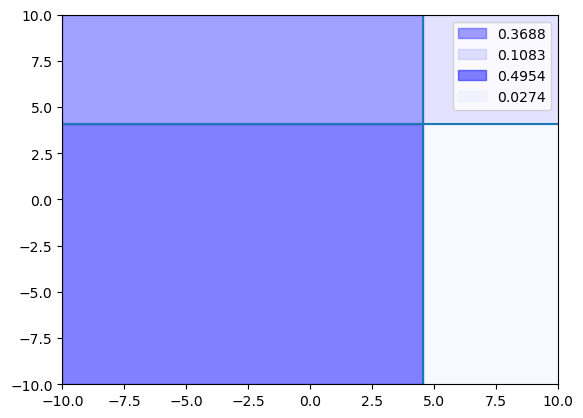

In [336]:
fig, ax = plt.subplots()

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.axvline(samples[0, 0])
ax.axhline(samples[0, 1])

ax.fill_between([-10, samples[0, 0]],samples[0, 1], 10, alpha = o1, label = round(o1, 4), color = "blue")
ax.fill_between([samples[0, 0], 10], samples[0, 1], 10, alpha = o2, label = round(o2, 4), color = "blue")
ax.fill_between([-10, samples[0, 0]], -10, samples[0, 1], alpha = o3, label = round(o3, 4), color = "blue")
ax.fill_between([samples[0, 0], 10], -10, samples[0, 1], alpha = o4, label = round(o4, 4), color = "blue")

ax.legend()

plt.show();

### Multi-sample

In [7]:
samples = stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]]).rvs(2)
samples = samples.tolist()

In [35]:
def generate_combinations(list1, list2):
    # Combine the two lists into a list of tuples
    combined = list(zip(list1, list2))
    
    # Use itertools.product to get all combinations
    result = list(product(*combined))
    
    return result

def cdf_coordinates(points, max_value):
    
    d = len(points[0])
    N = len(points)

    max_value = [[max_value]*d]*N

    return list(map(generate_combinations, points, max_value))
    
def compare_m_terms(m_term, m_terms):
    
    out_terms = [[0] * len(m_term)]

    max_count = m_term.tolist().count(1)


    for term in m_terms:
        for i, j in enumerate(zip(term, m_term)):
            j, k = j
            try:
                if max_count ==  term.tolist().count(1):
                    break
            except:
                pass

            if (j != k) and (j == 1):
                break

            if i == len(term) - 1:
                out_terms.append(term.tolist())

    return out_terms

def get_orthant_density(coordinates, dist = None):    

    max_value = max([max(e) for e in coordinates])
    d = len(coordinates[0])
    n_orthants = int(np.power(2, d))

    densities = dist.cdf(coordinates)
    densities = {point: density for point, density in zip(coordinates, densities)}
    
    orthant_densities = []

    m_count = 0
    scoped_points = list(filter(lambda x: x.count(max_value) == m_count, coordinates))
    scoped_densities = [((np.array(point) == max_value).astype(int), density) for point, density in densities.items() if point in scoped_points]

    while len(orthant_densities) < n_orthants:

        while scoped_densities:
            m_term, current_density = scoped_densities.pop()

            if m_count == 0:
                orthant_densities.append((m_term, current_density))
            else:
                m_terms = np.array([m[0] for m in orthant_densities])
                relevant_terms = compare_m_terms(m_term, m_terms)
                relevant_densities = [density for m, density in orthant_densities if m.tolist() in relevant_terms]
                orthant_density = current_density - (sum(relevant_densities))
                orthant_densities.append((m_term, orthant_density))

        m_count += 1
        scoped_points = list(filter(lambda x: x.count(max_value) == m_count, coordinates))
        scoped_densities = [((np.array(point) == max_value).astype(int), density)  for point, density in densities.items() if point in scoped_points]

    return orthant_densities

def sort_orthants(densities):
    orthants = [i[0].tolist() for i in densities]
    orthants.sort(reverse=True)
    sorted_orthants = []
    print(orthants)
    for orth in orthants:
        orth = orth[::-1]
        density = [e[1] for e in densities if e[0].tolist() == orth][0]
        sorted_orthants.append(density)

    return torch.Tensor(sorted_orthants)

In [36]:
dist = stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]])
samples = dist.rvs(2)

coordinates = cdf_coordinates(samples, 10)[0]

unsorted_densities = get_orthant_density(coordinates, stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]]))
print(unsorted_densities)

densities = sort_orthants(unsorted_densities)

print(densities)

[(array([0, 0, 0]), 0.015885706205135568), (array([1, 0, 0]), 0.11702665071736396), (array([0, 1, 0]), 0.03780416019965948), (array([0, 0, 1]), 0.01947780414839933), (array([1, 1, 0]), 0.27849528338366164), (array([1, 0, 1]), 0.1434888794606471), (array([0, 1, 1]), 0.046352489392359156), (array([1, 1, 1]), 0.3414690235330107)]
[[1, 1, 1], [1, 1, 0], [1, 0, 1], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 0, 1], [0, 0, 0]]
tensor([0.3415, 0.0464, 0.1435, 0.0195, 0.2785, 0.0378, 0.1170, 0.0159])


In [33]:
list(zip(coordinates, dist.cdf(coordinates)))

[((1.8575524465340996, 4.781439861052621, 3.2948551451372303),
  0.003024999265948179),
 ((1.8575524465340996, 4.781439861052621, 10), 0.01258528318115316),
 ((1.8575524465340996, 10, 3.2948551451372303), 0.0038646872772807174),
 ((1.8575524465340996, 10, 10), 0.0160787423450604),
 ((10, 4.781439861052621, 3.2948551451372303), 0.1881365589469886),
 ((10, 4.781439861052621, 10), 0.7827280812028228),
 ((10, 10, 3.2948551451372303), 0.2403600470051342),
 ((10, 10, 10), 0.9999999970402369)]

In [34]:
x = dist.cdf(coordinates)

x[1] - x[0]

0.00956028391520498

In [17]:
dist = stats.multivariate_normal([4 ,4, 4, 4], [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

samples = dist.rvs(2)

coordinates = cdf_coordinates(samples, 10)

d = torch.stack([sort_orthants(get_orthant_density(x, dist = dist)) for x in coordinates])

[[1, 1, 1, 1], [1, 1, 1, 0], [1, 1, 0, 1], [1, 1, 0, 0], [1, 0, 1, 1], [1, 0, 1, 0], [1, 0, 0, 1], [1, 0, 0, 0], [0, 1, 1, 1], [0, 1, 1, 0], [0, 1, 0, 1], [0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]]
[[1, 1, 1, 1], [1, 1, 1, 0], [1, 1, 0, 1], [1, 1, 0, 0], [1, 0, 1, 1], [1, 0, 1, 0], [1, 0, 0, 1], [1, 0, 0, 0], [0, 1, 1, 1], [0, 1, 1, 0], [0, 1, 0, 1], [0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]]


### More DDKS checks

In [52]:
from ddks.methods import ddKS

In [16]:
t = torch.rand(4, 2)

print(t)

d = ddKS()

d.get_orthants(t, t)


tensor([[0.6544, 0.6153],
        [0.6122, 0.2049],
        [0.5514, 0.1600],
        [0.7445, 0.3074]])


tensor([[0.2500, 0.0000, 0.2500, 0.5000],
        [0.7500, 0.0000, 0.0000, 0.2500],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.0000, 0.5000]])

In [94]:
t = torch.rand(8, 3)
u = torch.rand(1, 3) 

print(t)
print(u)
print()

d = ddKS()

d.get_orthants(t, u)

tensor([[0.6043, 0.0529, 0.7490],
        [0.7751, 0.1350, 0.8634],
        [0.0868, 0.5314, 0.0878],
        [0.9825, 0.8871, 0.0953],
        [0.1922, 0.0118, 0.9601],
        [0.9534, 0.1814, 0.5747],
        [0.6243, 0.2656, 0.7583],
        [0.1166, 0.6837, 0.6742]])
tensor([[0.8644, 0.4361, 0.6138]])



tensor([[0.0000, 0.1250, 0.0000, 0.5000, 0.1250, 0.1250, 0.1250, 0.0000]])

In [95]:
torch.ge(t, u).unique(return_counts = True, dim = 0)

(tensor([[False, False,  True],
         [False,  True, False],
         [False,  True,  True],
         [ True, False, False],
         [ True,  True, False]]),
 tensor([4, 1, 1, 1, 1]))

In [56]:
import plotly.express as px
import pandas as pd

print()

fig = px.scatter_3d(pd.DataFrame(t.numpy()), x = 0, y = 1, z = 2)

fig.show()

### Ordering orthants

In [18]:
dist = stats.multivariate_normal([4 ,4], [[1, 0], [0, 1]])

samples = dist.rvs(4)

coordinates = cdf_coordinates(samples, 10)[0]

get_orthant_density(coordinates, dist)

tensor([0.0433, 0.0998, 0.2592, 0.5977])

In [20]:

dist = stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]])

samples = dist.rvs(4)

coordinates = cdf_coordinates(samples, 10)[0]
print(coordinates)

get_orthant_density(coordinates, dist)

[(3.838299484511696, 4.525022842386881, 3.62579120616773), (3.838299484511696, 4.525022842386881, 10), (3.838299484511696, 10, 3.62579120616773), (3.838299484511696, 10, 10), (10, 4.525022842386881, 3.62579120616773), (10, 4.525022842386881, 10), (10, 10, 3.62579120616773), (10, 10, 10)]


tensor([0.1092, 0.0844, 0.2552, 0.0599, 0.1971, 0.0463, 0.1399, 0.1081])

In [21]:
dist.cdf(coordinates[1]) - dist.cdf(coordinates[0])

0.19707849392273286

**Orthant density order:**

| x         | y         | z         |
|-----------|-----------|-----------|
| $x_1$     | $y_1$     | $z_1$     |
| $x_1$     | $y_1$     | $z_{max}$ |
| $x_1$     | $y_{max}$ | $z_1$     |
| $x_1$     | $y_{max}$ | $z_{max}$ |
| $x_{max}$ | $y_1$     | $z_1$     |
| $x_{max}$ | $y_1$     | $z_{max}$ |
| $x_{max}$ | $y_{max}$ | $z_1$     |
| $x_{max}$ | $y_{max}$ | $z_{max}$ |

**Orthant sampling order**

| x         | y         | z         |
|-----------|-----------|-----------|
| $x_{max}$ | $y_{max}$ | $z_{max}$ |
| $x_{max}$ | $y_{max}$ | $z_1$     |
| $x_{max}$ | $y_1$     | $z_{max}$ |
| $x_{max}$ | $y_1$     | $z_1$     |
| $x_1$     | $y_{max}$ | $z_{max}$ |
| $x_1$     | $y_{max}$ | $z_1$     |
| $x_1$     | $y_1$     | $z_{max}$ |
| $x_1$     | $y_1$     | $z_1$     |

After inspecting the populated orthants under "More DDKS checks" it appear the ordering of each orthant is the reversed version of the that output by the CDF function. Therefore, simply reversing the CDF function output should result in two comparable tensors.

### Check adKS implementation

In [4]:
from ddks.methods import adKS
from scipy import stats
import torch

p_dist = stats.multivariate_normal([4 ,4], [[1, 0], [0, 1]])
t_dist = stats.multivariate_normal([4, 4], [[1, 0], [0, 1]])

pred = torch.Tensor(p_dist.rvs(1000))#.unsqueeze(0)
true = torch.Tensor(t_dist.rvs(1000))#.unsqueeze(0)

print(f"""
      Samples
      -------
      Predictions: {pred}
      True: {true}
      """
      )
print()

a = adKS()

a(pred, true, t_dist, 10)

# This implementation works for 2 dimensions



      Samples
      -------
      Predictions: tensor([[3.6845, 5.1687],
        [6.0346, 4.4620],
        [4.2901, 4.2780],
        ...,
        [3.0834, 3.4433],
        [3.2369, 5.0884],
        [4.3584, 3.6950]])
      True: tensor([[5.0924, 3.3463],
        [4.9250, 4.8452],
        [6.8617, 3.7800],
        ...,
        [4.3264, 3.0150],
        [4.6827, 5.9006],
        [4.3646, 4.8607]])
      



tensor(0.0335)

In [47]:
print(f"""
      {t_dist.cdf((10, 10)) - (t_dist.cdf((pred[0, 0], 10)) - t_dist.cdf(pred[0,:])) - (t_dist.cdf((10, pred[0, 1])) - t_dist.cdf(pred[0,:])) - t_dist.cdf(pred[0,:])}
      {t_dist.cdf((pred[0, 0], 10)) - t_dist.cdf(pred[0,:])}
      {t_dist.cdf((10, pred[0, 1])) - t_dist.cdf(pred[0,:])}
      {t_dist.cdf(pred[0,:])}
      """)


      0.16365203027872688
      0.5440319500141693
      0.06759812446983826
      0.2247178932640902
      


In [7]:
from ddks.methods import adKS
from scipy import stats
import torch

p_dist = stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]])
t_dist = stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]])

pred = torch.Tensor(p_dist.rvs(1000))
true = torch.Tensor(t_dist.rvs(1000))#.unsqueeze(0)

# print(pred)
# print(true)
# print()
# print(torch.ge(pred, true))

# print(pred)
# print(true)

a = adKS()

a(pred, true, t_dist, 10)


tensor(0.0386)

In [8]:
from ddks.methods import adKS
from scipy import stats
import torch

p_dist = stats.multivariate_normal([4 ,4, 4, 4], [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
t_dist = stats.multivariate_normal([4 ,4, 4, 4], [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

pred = torch.Tensor(p_dist.rvs(1000))
true = torch.Tensor(t_dist.rvs(1000))#.unsqueeze(0)

# print(pred)
# print(true)
# print()
# print(torch.ge(pred, true))

# print(pred)
# print(true)

a = adKS()

a(pred, true, t_dist, 10)


tensor(0.0493)

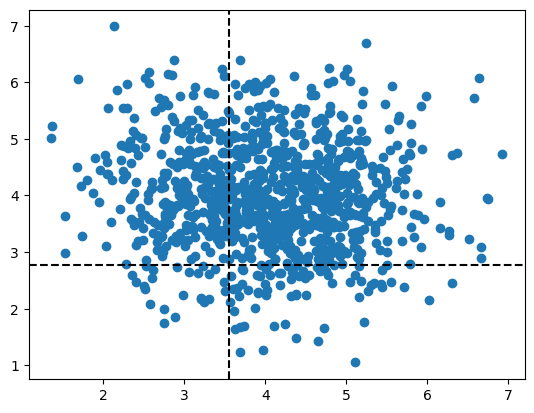

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(pred[:,0], pred[:, 1])
ax.axvline(true[0, 0], color = "black", linestyle = "--")
ax.axhline(true[0, 1], color = "black", linestyle = "--")


# Problem 1

In [3]:
p1 = Problem1()

### PyMC

In [4]:
p1._pymc_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [13]:
p1._model_dist(stats.norm, p1.pymc_params)

### Pyro

In [5]:
p1._pyro_model()

Sample: 100%|██████████| 1200/1200 [00:01, 723.38it/s, step size=1.07e+00, acc. prob=0.937]


In [7]:
p1._model_dist(stats.norm, p1.pyro_params)

### Stan

In [6]:
p1._stan_model()

15:31:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:31:20 - cmdstanpy - INFO - CmdStan done processing.


In [11]:
p1._model_dist(stats.norm, p1.stan_params)

### Distance

In [ ]:
p = p1._model_dist(stats.norm, p1.conjugate_model.posterior_predictive_params)
q = p1._model_dist(stats.norm, p1.stan_params)

support_lim = p1.true_params["loc"] + (4*p1.true_params["scale"])

p1.get_distance("ks_test", p, q, support_lim)